TFIM
1. 基底状態のSA と 横磁場 hx tfim_sa_hx_n6-12-18-24

In [4]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1439055708988375082/6iiXA8J_3Bn1RPWZ8XmPfmfSJp_PkGdaIzt495Ao2fbu_a09VnMJpxmrnSyfN4Wtyc7T"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', 's', '^', 'v', 'D', '*', '+', 'x']
colors = [
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:brown",
    "tab:gray",
]

# hx スイープ用: 小さい hx → 薄い / 大きい hx → 濃い紫
colors_hx = [
    "thistle",
    "plum",
    "orchid",
    "mediumorchid",
    "mediumpurple",
    "purple",
    "indigo",
]

# N スイープ用: N が大きいほど「暖色・濃い」方向
colors_N = [
    "tab:blue",   # 最小 N
    "tab:cyan",
    "tab:green",
    "tab:olive",
    "tab:orange",
    "tab:red",    # 最大 N
    "tab:brown",
    "tab:gray",   # おまけ枠（補助曲線にも使える）
]
OUTDIR = Path("charts")
def save_fig(fig, stem: str):
    fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
    print(f"saved: {OUTDIR / (stem + '.pdf')}")

# データ保存
DATADIR = Path("data")

# データ読み込み例
# fname = DATADIR / "square_sa_tcut.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

In [2]:
# ========= キャッシュ付きヘルパ =========
@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = [0.5 * M for M in (qt.sigmax(), qt.sigmaz())]
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites


def simulate(N, J, hx):
    Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites = get_ops(N)
    H_full = - J * (Hex_rest_unit + Hcut_unit) - hx * Hhx_unit
    E0, psi0 = H_full.groundstate(sparse=True)
    rhoL = qt.ptrace(psi0, left_sites)
    return float(qt.entropy_vn(rhoL, base=2))

/var/folders/v5/c_qlc9ds44ldxhm179s7h1mh0000gn/T/ipykernel_27000/961572767.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


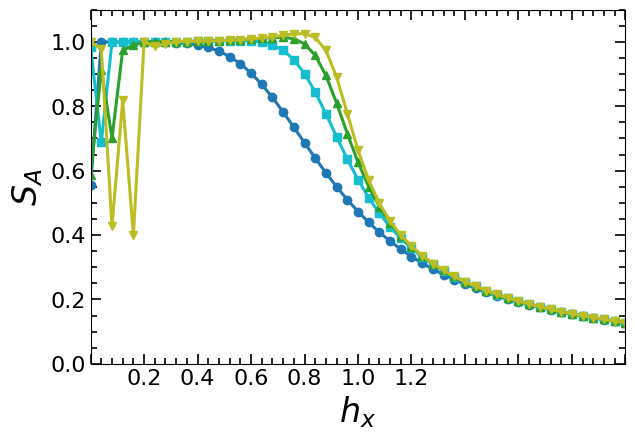

✅ Discord 通知送信 OK
saved: charts/tfim_sa_hx_n6-12-18-24.pdf


In [7]:
# 1 基底状態のSA と 横磁場 hx 6-12-18-24
N_list = [6, 12, 18, 24]
J = 1.0
hx_list = np.linspace(0.0, 1.0, 51)

# SA_all = []


nstamp = "-".join(map(str, N_list))
fname = DATADIR / f"tfim_sa_hx_n{nstamp}.npz"

dat = np.load(fname)

SA_all = dat["SA_all"]

fig, ax = plt.subplots(figsize=(6.9, 4.6))
inward_ticks(ax)

for i, N in enumerate(N_list):
    # print(f"N is {N}")
    # SA_list = []
    # for hx in hx_list:
    #     SA = simulate(N=N, J=J, hx=hx)
    #     print(f"hx is {hx}")
    #     SA_list.append(SA)

    # SA_all.append(SA_list)

    ax.plot(
        hx_list,
        # SA_list,
        SA_all[i],
        marker=markers[i],
        color=colors_N[i],
        markersize=6.0,
        linewidth=2.2,
    )

# ---- 軸まわり設定 ----
ax.set_xlim(0.0, 1.0)  # hx_list が 0〜1 なのでここは 1.0 でよさそう
ax.set_xlabel(r"$h_x$", fontsize=24)
ax.set_ylim(0.0, 1.1)
ax.set_ylabel(r"$S_A$", fontsize=24)

ax.xaxis.set_major_locator(MultipleLocator(0.1))

plt.show()

# # データ保存
# SA_all = np.array(SA_all)  # (len(N_list), len(hx_list)) の 2次元配列にしておく
# nstamp = "-".join(map(str, N_list))
# npz_path = DATADIR / f"tfim_sa_hx_n{nstamp}.npz"
# np.savez(
#     npz_path,
#     N_list=np.array(N_list),
#     hx_list=hx_list,
#     SA_all=SA_all,
# )

notify_discord(message="tfim sim 7-1 done")
save_fig(fig=fig, stem=f"tfim_sa_hx_n{nstamp}")